In [19]:
all_connections = {
    "panoptic": [
        (7, 8),
        (6, 7),
        (2, 6),
        (2, 12),
        (12, 13),
        (13, 14),
        (2, 0),
        (0, 3),
        (0, 9),
        (3, 4),
        (4, 5),
        (9, 10),
        (10, 11),
        (0, 16),
    ],
    "skiPose": [
        [0, 1],
        [1, 2],
        [2, 3],
        [0, 4],
        [4, 5],
        [5, 6],
        [8, 9],
        [9, 10],
        [8, 11],
        [11, 12],
        [12, 13],
        [0, 7],
        [14, 15],
        [15, 16],
        [7, 8],
        [14, 8],
    ],
}

import sys

sys.path.append("..")

from pose_estimation.models import getPoseEstimModel
from pose_estimation.utils import getDatasetLoader, getLatestModel
from dataloaders.datasets import out_joints, pose_datasets
import torch
from torchvision.models.resnet import ResNet50_Weights, ResNet18_Weights
import torchvision.transforms as T


dataset = "skiPose"
models_out = [
    "skiPose" for i in range(3)
] 
datasets_dir = "../datasets"
models = [
    "../trained_models/simsiam18Ski_estim_ski_50%",
    "../trained_models/simsiam18Ski_estim_ski_full",
    "../trained_models/resnet18_estim_ski_full",
]
names = [
    "SimSiam 18 50%",
    "SimSiam 18 full",
    "ResNet 18 full",
]
backbones = [ "resnet50" for i in range(0)] + ["resnet18" for i in range(3)]

architectures = [
    [128] for i in range(len(models))
]
activations = [
    "gelu" for i in range(len(models))
]
out_dim = [out_joints[model_out] * 3 for model_out in models_out]
LN = [
    True for i in range(len(models))
]
device = "cuda" if torch.cuda.is_available() else "cpu"

test_data = {}

transforms = ResNet18_Weights.DEFAULT.transforms()
transforms = T.Compose([T.ToPILImage(), transforms])
_, _, test_data["resnet18"] = pose_datasets[dataset](transforms, datasets_dir)


transforms = ResNet50_Weights.DEFAULT.transforms()
transforms = T.Compose([T.ToPILImage(), transforms])
_, _, test_data["resnet50"] = pose_datasets[dataset](transforms, datasets_dir)

clear_models = []
for i, model in enumerate(models):
    print("loading model: ", model, f" with {architectures[i]} {out_dim[i]} {backbones[i]} {LN[i]} {activations[i]}") 
    clear_model = getPoseEstimModel(
        "",
        "resnet",
        architectures[i],
        out_dim[i],
        device,
        backbones[i],
        LN[i],
        activations[i],
    )
    model_checkpoint = getLatestModel(model)
    print("\tloading model from: ", model_checkpoint)
    clear_model.load_state_dict(
        torch.load(model_checkpoint, map_location=torch.device(device))
    )
    clear_models.append(clear_model)
    print("\tmodel loaded")

# print(clear_model1 == clear_model2)
if device == "cpu":
    for model in clear_models:
        model = model.module

loading model:  ../trained_models/simsiam18Ski_estim_ski_50%  with [128] 51 resnet18 True gelu
	loading model from:  ../trained_models/simsiam18Ski_estim_ski_50%/epoch_37.pt
	model loaded
loading model:  ../trained_models/simsiam18Ski_estim_ski_full  with [128] 51 resnet18 True gelu


C:\Users\david\AppData\Local\Temp\ipykernel_7296\49892658.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_checkpoint, map_location=torch.device(device

	loading model from:  ../trained_models/simsiam18Ski_estim_ski_full/epoch_33.pt
	model loaded
loading model:  ../trained_models/resnet18_estim_ski_full  with [128] 51 resnet18 True gelu
	loading model from:  ../trained_models/resnet18_estim_ski_full/epoch_32.pt
	model loaded


In [23]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
from pose_estimation.functions import find_rotation_mat  # As per your instruction
from scipy.spatial.transform import Rotation as R
from pose_estimation.functions import get_loss


def plot_models(
    models,
    backbones,
    index,
    all_connections,
    test_data,
    dataset,
    model_outs,
    model_names,
    show_image=True,
    models_to_plot=None,
):
    """
    Plots predictions from multiple models against a single ground truth,
    with each pose normalized individually to the range [0, 1] while maintaining proportions.
    Aligns each pose to be upright (perpendicular to the floor) and facing the viewer.
    Each pose is plotted in a separate subplot for clarity.

    Args:
        models (list): A list of trained pose estimation models.
        backbones (list): A list of backbone names corresponding to each model.
        index (int): The index of the data sample to visualize.
        all_connections (dict): A dictionary mapping dataset names to their joint connections.
        test_data (dict): A dictionary containing test datasets mapped by backbone names.
        dataset (str): The name of the dataset to use for plotting (determines the connections for ground truth).
        model_outs (list): A list of dataset names corresponding to each model's output format, used to get connections.
        model_names (list): A list of names for each model, used in plot titles and legends.
        show_image (bool): Whether to display the original image alongside the 3D plots.
        models_to_plot (list or None): List of indices of models to plot. If None, all models are plotted.

    Raises:
        ValueError: If the lengths of models, backbones, model_outs, and model_names do not match.
        ValueError: If the specified dataset is not found in all_connections.
    """
    # Validate input lengths
    if not (len(models) == len(backbones) == len(model_outs) == len(model_names)):
        raise ValueError(
            "The lengths of models, backbones, model_outs, and model_names must be equal."
        )

    # Validate dataset
    if dataset not in all_connections:
        raise ValueError(f"Dataset '{dataset}' not found in all_connections.")

    num_models = len(models)

    # Handle models_to_plot
    if models_to_plot is None:
        models_to_plot = list(range(num_models))
    else:
        # Validate models_to_plot
        if not all(0 <= idx < num_models for idx in models_to_plot):
            raise ValueError("models_to_plot contains invalid model indices.")

    # Collect ground truth pose and image from the first backbone's test data
    first_backbone = backbones[0]
    if first_backbone not in test_data:
        raise ValueError(f"Test data key '{first_backbone}' not found in test_data.")

    ground_sample = test_data[first_backbone][index]
    ground_image = ground_sample["image"]
    ground_coords = ground_sample["poses_3d"].reshape((-1, 3))
    device = next(models[0].parameters()).device
    ground_coords_tensor = torch.tensor(ground_coords, dtype=torch.float32).to(device)

    # Align and normalize ground truth pose
    ground_coords_aligned = align_pose(ground_coords_tensor, dataset)
    ground_coords_normalized = normalize_pose(ground_coords_aligned)

    # Determine subplot layout
    total_plots = (
        len(models_to_plot) + (1 if show_image else 0) + 1
    )  # +1 for ground truth
    max_cols = 4
    ncols = min(total_plots, max_cols)
    nrows = (total_plots + max_cols - 1) // max_cols  # Ceiling division
    fig = plt.figure(figsize=(6 * ncols, 6 * nrows))

    plot_idx = 1

    # Plot each model's prediction in separate subplots
    losses = {}
    pred_normalized = {}
    model_connections = {}
    for i in models_to_plot:
        model = models[i]
        backbone = backbones[i]
        model_out = model_outs[i]
        model_name = model_names[i]
        pred_pose = get_model_prediction(
            model, backbone, test_data, index, model_out
        )
        pred_aligned = align_pose_to_gt(pred_pose, ground_coords_aligned)
        loss = get_loss(
            pred_pose.view(1, -1),
            torch.tensor(ground_sample["poses_3d"]).unsqueeze(0).to(pred_pose.device),
        )
        pred_normalized[model_name] = normalize_pose(pred_aligned)
        model_connections[model_name] = all_connections[model_out]
        
        losses[model_name] = loss

    
    # sort the losses
    losses = dict(sorted(losses.items(), key=lambda item: item[1], reverse=True))
    print("Ranking:")
    for i, model in enumerate(losses):
        print(f'\t{i+1} - "{model}" Loss {losses[model]}')
        
        ax_model = fig.add_subplot(nrows, ncols, plot_idx, projection="3d")
        plot_pose(
            ax_model,
            pred_normalized[model],
            model_connections[model],
            title=model,
            color="darkred",
            loss=losses[model],
            image=ground_image,
        )
        plot_idx += 1

    # Plot ground truth
    gt_connections = all_connections[dataset]
    ax_gt = fig.add_subplot(nrows, ncols, plot_idx, projection="3d")
    plot_pose(
        ax_gt, ground_coords_normalized, gt_connections, title="Ground Truth", color="b", image=ground_image
    )
    plot_idx += 1
    
    # Plot the image if required
    if show_image:
        ax_img = fig.add_subplot(nrows, ncols, plot_idx)
        plot_image(ax_img, ground_image)
        plot_idx += 1

    plt.tight_layout()
    plt.show()


def normalize_pose(pose):
    # Convert to NumPy array if it's a torch tensor
    if isinstance(pose, torch.Tensor):
        pose = pose.cpu().numpy()
    elif isinstance(pose, np.ndarray):
        pass
    else:
        raise TypeError("Pose must be a torch.Tensor or numpy.ndarray.")

    return pose


def get_model_prediction(model, backbone, test_data, index, model_out):
    """Gets and processes the prediction from a single model."""
    device = next(model.parameters()).device
    sample = test_data[backbone][index]
    image = sample["image"]
    image_tensor = image.unsqueeze(0).to(device)

    # Model Prediction
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        pred_model = model(
            image_tensor
        )  # Assuming model outputs (batch_size, num_joints*3)
        pred = pred_model[0].reshape((-1, 3)).detach()

    return pred

def align_pose_to_gt(pose1, pose2):
    """
    Aligns two poses by finding the optimal rotation matrix that minimizes the distance between them.

    Args:
        pose1 (torch.Tensor): First pose tensor of shape (N, 3).
        pose2 (torch.Tensor): Second pose tensor of shape (N, 3).

    Returns:
        torch.Tensor: Aligned pose tensor of shape (N, 3).
    """
    # Compute the optimal rotation matrix
    rotation_mat = find_rotation_mat(pose1, pose2)

    # Apply the rotation matrix to pose1
    pose1_aligned = torch.matmul(pose1, rotation_mat.T)

    return pose1_aligned

def align_pose(pose_tensor, dataset_name):
    """
    Aligns the pose to be upright (perpendicular to the floor) and optionally rotates around the Z-axis.

    Args:
        pose_tensor (torch.Tensor): Pose tensor of shape (N, 3).
        dataset_name (str): The name of the dataset to determine joint indices.
        rotate_z (bool): Whether to rotate the pose around the Z-axis to face the viewer.

    Returns:
        torch.Tensor: Aligned (and optionally rotated) pose tensor of shape (N, 3).
    """
    # Center the pose around its mean
    pose_centered = pose_tensor - pose_tensor.mean(dim=0)

    # Define joint indices based on the dataset
    # Adjust these indices according to your dataset's joint definitions
    if dataset_name == "panoptic":
        hip_index = 2
        head_index = 14
        left_shoulder_index = 9
        right_shoulder_index = 3
    elif dataset_name == "skiPose":
        hip_index = 0
        head_index = 14
        left_shoulder_index = 5
        right_shoulder_index = 2
    else:
        # Default indices
        hip_index = 0
        head_index = -1
        left_shoulder_index = 5
        right_shoulder_index = 6

    # Compute the "up" vector (from hips to head)
    if hip_index < len(pose_centered) and head_index < len(pose_centered):
        up_vector = pose_centered[head_index] - pose_centered[hip_index]
    else:
        up_vector = torch.tensor(
            [0, 0, 1], dtype=pose_tensor.dtype, device=pose_tensor.device
        )

    # Normalize the up vector
    up_vector_norm = torch.norm(up_vector)
    if up_vector_norm == 0:
        up_vector = torch.tensor(
            [0, 0, 1], dtype=pose_tensor.dtype, device=pose_tensor.device
        )
    else:
        up_vector = up_vector / up_vector_norm

    # Desired up vector while keeping the angle with the XY-plane
    target_up = torch.tensor(
            [up_vector[1], up_vector[0], 1], dtype=pose_tensor.dtype, device=pose_tensor.device
        )
    # Normalize the target up vector
    target_up_norm = torch.norm(target_up)
    if target_up_norm == 0:
        target_up = torch.tensor(
            [0, 0, 1], dtype=pose_tensor.dtype, device=pose_tensor.device
        )
    else:
        target_up = target_up / target_up_norm

    # Compute rotation to align up_vector with target_up
    rotation_mat = compute_alignment_rotation(up_vector, target_up)

    # Apply rotation
    pose_aligned = torch.matmul(pose_centered, rotation_mat.T)
    
    # alig the shoulders vector to be parallel to y vector while keeping the angle with the ZX-plane
    left_shoulder = pose_aligned[left_shoulder_index]
    right_shoulder = pose_aligned[right_shoulder_index]
    shoulders_vector = right_shoulder - left_shoulder
    shoulders_vector = shoulders_vector / torch.norm(shoulders_vector)
    
    target_shoulder = torch.tensor(
        [shoulders_vector[0], 1, shoulders_vector[2]], dtype=pose_tensor.dtype, device=pose_tensor.device
    )
    # Normalize the target up vector
    target_shoulder_norm = torch.norm(target_shoulder)
    if target_shoulder_norm == 0:
        target_shoulder = torch.tensor(
            [0, 1, 0], dtype=pose_tensor.dtype, device=pose_tensor.device
        )
    else:
        target_shoulder = target_shoulder / target_shoulder_norm
        
    rotation_mat = compute_alignment_rotation(shoulders_vector, target_shoulder)
    pose_aligned = torch.matmul(pose_aligned, rotation_mat.T)

    return pose_aligned

def compute_alignment_rotation(source_vector, target_vector):
    """
    Computes the rotation matrix that aligns source_vector to target_vector.

    Args:
        source_vector (torch.Tensor): Source vector of shape (3,).
        target_vector (torch.Tensor): Target vector of shape (3,).

    Returns:
        torch.Tensor: Rotation matrix of shape (3, 3).
    """
    v = torch.cross(source_vector, target_vector)
    c = torch.dot(source_vector, target_vector)
    s = torch.norm(v)

    if s == 0:
        # Vectors are parallel
        if c > 0:
            # Same direction
            return torch.eye(3, dtype=source_vector.dtype, device=source_vector.device)
        else:
            # Opposite direction
            # Rotate 180 degrees around any orthogonal axis
            orthogonal_axis = torch.tensor(
                [1, 0, 0], dtype=source_vector.dtype, device=source_vector.device
            )
            if torch.allclose(source_vector, orthogonal_axis):
                orthogonal_axis = torch.tensor(
                    [0, 1, 0], dtype=source_vector.dtype, device=source_vector.device
                )
            v = torch.cross(source_vector, orthogonal_axis)
            v = v / torch.norm(v)
            return rotation_matrix_from_axis_angle(v, torch.pi)
    else:
        kmat = torch.tensor(
            [[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]],
            dtype=source_vector.dtype,
            device=source_vector.device,
        )
        rotation_matrix = (
            torch.eye(3, dtype=source_vector.dtype, device=source_vector.device)
            + kmat
            + kmat @ kmat * ((1 - c) / (s**2))
        )
        return rotation_matrix


def rotation_matrix_from_axis_angle(axis, angle):
    """
    Computes the rotation matrix from an axis and angle using Rodrigues' rotation formula.

    Args:
        axis (torch.Tensor): Rotation axis of shape (3,).
        angle (float): Rotation angle in radians.

    Returns:
        torch.Tensor: Rotation matrix of shape (3, 3).
    """
    K = torch.tensor(
        [[0, -axis[2], axis[1]], [axis[2], 0, -axis[0]], [-axis[1], axis[0], 0]],
        dtype=axis.dtype,
        device=axis.device,
    )

    R = (
        torch.eye(3, dtype=axis.dtype, device=axis.device)
        + torch.sin(angle) * K
        + (1 - torch.cos(angle)) * torch.matmul(K, K)
    )
    return R


def plot_pose(ax, pose, connections, title="", color="r", loss=0, image=None):
    """Plots a single pose in a 3D subplot."""
    # Compute minimum X value of the pose to position the image behind it
    x_max_modulus = np.max(np.abs(pose[:, 0]))
    y_max_modulus = np.max(np.abs(pose[:, 1]))
    xy_max = max(x_max_modulus, y_max_modulus)
    x_image_plane = 1.5  # Slightly behind the pose

    if image is not None:
        # Process and normalize the image
        image = image.permute(1, 2, 0).cpu().numpy()
        image = image - image.min()
        if image.max() != 0:
            image = image / image.max()
        else:
            image = np.zeros_like(image)

        # Handle grayscale images by converting them to RGB
        if image.ndim == 2 or image.shape[2] == 1:
            image = np.squeeze(image)
            image = np.stack([image, image, image], axis=-1)


        # Flip the image vertically to match the plot coordinate system
        facecolors = image[::-1, :, :]
        # rotate 90 degrees
        facecolors = np.rot90(facecolors, 1)

        # Add an alpha channel to make the image semi-transparent
        alpha = 1  # Adjust transparency between 0 (transparent) and 1 (opaque)
        if facecolors.shape[2] == 3:
            alpha_channel = np.full((*facecolors.shape[:2], 1), alpha)
            facecolors = np.concatenate([facecolors, alpha_channel], axis=2)
        else:
            facecolors[:, :, 3] = alpha

        # Create grids for Y and Z (since we're plotting on the plane X = x_image_plane)
        y = np.linspace(-xy_max, xy_max, facecolors.shape[0])
        z = np.linspace(-xy_max, xy_max, facecolors.shape[1])
        Y, Z = np.meshgrid(y, z, indexing='ij')
        X = np.full_like(Y, x_image_plane)

        # Plot the image on the plane X = x_image_plane
        ax.plot_surface(
            X,
            Y,
            Z,
            rstride=1,
            cstride=1,
            facecolors=facecolors,
            shade=False,
            antialiased=False,
            alpha=alpha,
            zorder=0  # Attempt to control rendering order
        )

    # Now plot the pose so it's rendered on top of the image
    # Plot the lines first
    for connection in connections:
        start, end = connection
        if start < len(pose) and end < len(pose):
            ax.plot(
                [pose[start, 0], pose[end, 0]],
                [pose[start, 1], pose[end, 1]],
                [pose[start, 2], pose[end, 2]],
                c=color,
                linewidth=4,
                zorder=1  # Attempt to prioritize rendering
            )

    # Plot the points
    ax.scatter(pose[:, 0], pose[:, 1], pose[:, 2], c=color, s=50, zorder=2)

    # Set plot title and labels, rounding to nearest integer
    ax.set_title(f"{title} - MPJPE {math.ceil(loss*1000)}", fontsize=25)

    # Adjust axes limits to include the image and pose
    ax.set_xlim(-xy_max, 1.5)
    ax.set_ylim(-xy_max, xy_max)
    ax.set_zlim(-xy_max, xy_max)

    # Adjust view angle to look along the X-axis
    ax.view_init(elev=10, azim=-230)  # Look along negative X-axis

    # Remove grid and ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])



def plot_image(ax, image_tensor):
    """Plots the image in a subplot."""
    # Convert image tensor to numpy array
    img = image_tensor.clone().detach().cpu()
    if img.shape[0] == 1:
        img = img.squeeze(0)  # Remove channel dimension for grayscale
        img = img.numpy()
        cmap = "gray"
    else:
        img = img.permute(1, 2, 0).numpy()
        cmap = None  # RGB image

    # Ensure image values are in [0,1]
    img = img - img.min()
    if img.max() != 0:
        img = img / img.max()

    ax.imshow(img, cmap=cmap)
    ax.set_title("Original Image")
    ax.axis("off")


In [21]:
# generate unique indexes
indexes = np.random.choice(len(test_data["resnet50"]), 10, replace=False) // 6 + 3
indexes = [68]

________________________________________________________
Index:  68
Ranking:
	1 - "ResNet 18 full" Loss 0.09304876625537872
	2 - "SimSiam 18 full" Loss 0.059811607003211975
	3 - "SimSiam 18 50%" Loss 0.056796327233314514


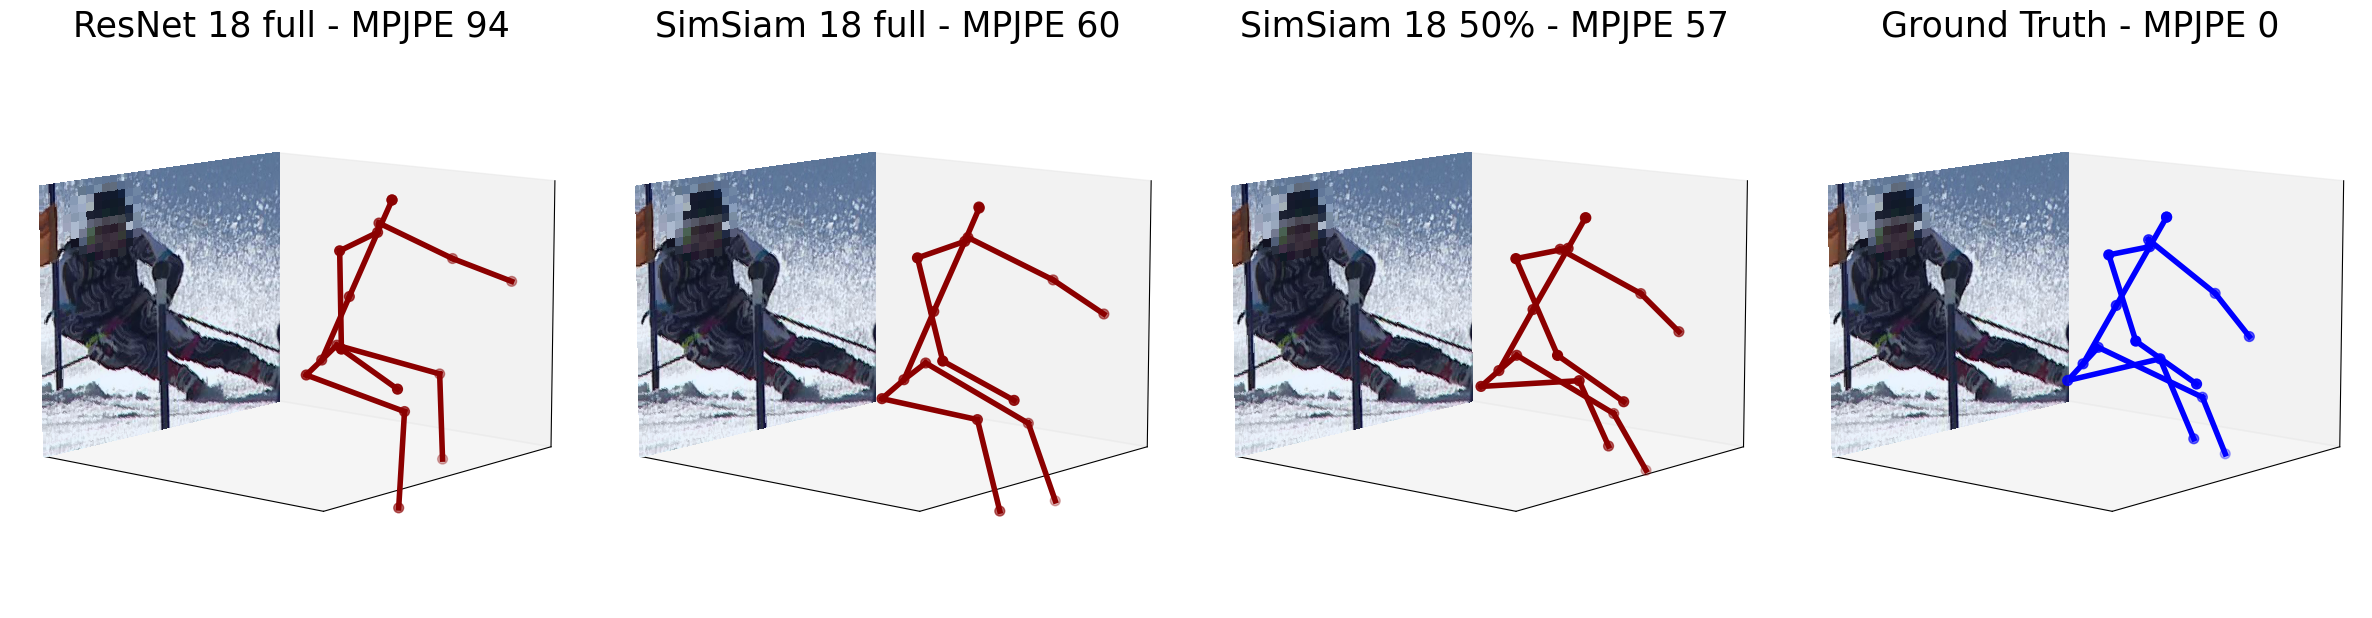

In [24]:
for index in indexes:

    print("________________________________________________________")

    print("Index: ", index)

    plot_models(
        clear_models,
        backbones,
        index,
        all_connections,
        test_data,
        dataset,
        models_out,
        names,
        show_image=False,
        models_to_plot=None,
    )
    